<h1>Normalisation for the removal of batch effect</h1>

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.normalisation.normalise import Normalise
from immunova.flow.supervised_algo.utilities import calculate_reference_sample, find_common_features
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

In [3]:
texp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()

<h2>Calculate Reference Sample</h2>

In [4]:
exclude = ['142-09_pdmc_t',
 '210-14_pdmc_t',
 '273-01_pdmc_t',
 '276-01_pdmc_t',
 '286-03_pdmc_t',
 '298-01_pdmc_t',
 '305-01_pdmc_t',
 '308-02R_pdmc_t',
 '315-01_pdmc_t',
 '322-01_pdmc_t',
 '323-01_pdmc_t',
 '324-01_pdmc_t',
 '302-01_pdmc_t']

In [9]:
reference_sample = calculate_reference_sample(texp, exclude_samples=exclude)

Running comparisons for 165-09_pdmc_t
Running comparisons for 175-09_pdmc_t
Running comparisons for 209-03_pdmc_t
Running comparisons for 209-05_pdmc_t
Running comparisons for 239-02_pdmc_t
Running comparisons for 239-04_pdmc_t
Running comparisons for 251-07_pdmc_t
Running comparisons for 251-08_pdmc_t
Running comparisons for 254-04_pdmc_t
Running comparisons for 254-05_pdmc_t
Running comparisons for 255-04_pdmc_t
Running comparisons for 255-05_pdmc_t
Running comparisons for 264-02_pdmc_t
Running comparisons for 267-02_pdmc_t
Running comparisons for 286-04_pdmc_t
Running comparisons for 294-02_pdmc_t
Running comparisons for 294-03_pdmc_t
Running comparisons for 305-03_pdmc_t
Running comparisons for 306-01_pdmc_t
Running comparisons for 308-03R_pdmc_t
Running comparisons for 308-04_pdmc_t
Running comparisons for 310-01_pdmc_t
Running comparisons for 315-02_pdmc_t
Running comparisons for 318-01_pdmc_t
Running comparisons for 326-01_pdmc_t
Running comparisons for 237-06_pdmc_t
Running com

In [7]:
reference_sample

'288-02_pdmc_t'

In [5]:
reference_sample = '288-02_pdmc_t'

<h2>Normalise the first sample</h2>

In [6]:
all_samples = [x for x in texp.list_samples() if x not in exclude]

In [8]:
features = find_common_features(experiment=texp)

In [7]:
features = ['CD45RA',
 'Va7.2',
 'Time',
 'FSC-A',
 'FSC-H',
 'SSC-A',
 'CD161',
 'CD8',
 'CXCR3',
 'Vd2',
 'CD4',
 'CD3',
 'CD27',
 'PanGD',
 'L/D',
 'CCR7',
 'SSC-W']

In [8]:
norm = Normalise(experiment=texp,
                source_id=all_samples[0],
                root_population='liveCD3',
                features=features,
                reference_sample=reference_sample)

setting scales using KNN
Scales: [1.3923534982848818, 2.7847069965697635, 5.569413993139527]
setting all scale weights to 1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 884 samples, validate on 99 samples
Epoch 1/500
884/884 [==============================] - 1s 764us/step - loss: 1.5858 - val_loss: 1.6182
Epoch 2/500
884/884 [==============================] - 0s 106us/step - loss: 1.5861 - val_loss: 1.6179
Epoch 3/500
884/884 [==============================] - 0s 108us/step - loss: 1.5725 - val_loss: 1.6176
Epoch 4/500
884/884 [==============================] - 0s 107us/step - loss: 1.5580 - val_loss: 1.6172
Epoch 5/500
884/884 [==============================] - 0s 109us/step - loss: 1.5418 - val_loss: 1.6167
Epoch 6/500
884/884 [==============================] - 0s 107us/step - loss: 1.5257 - val_loss: 1.6161
Epoch 7/500
884/884 [==============================] - 0s 112us/step - loss: 1.5108 - val_loss: 1.6156
Epoch 8/500
88

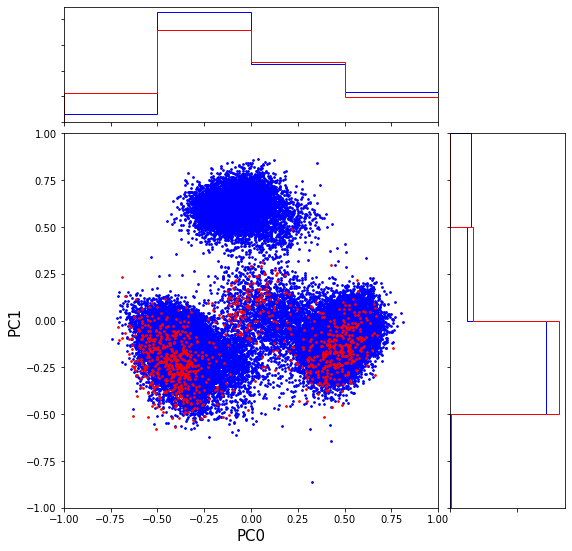

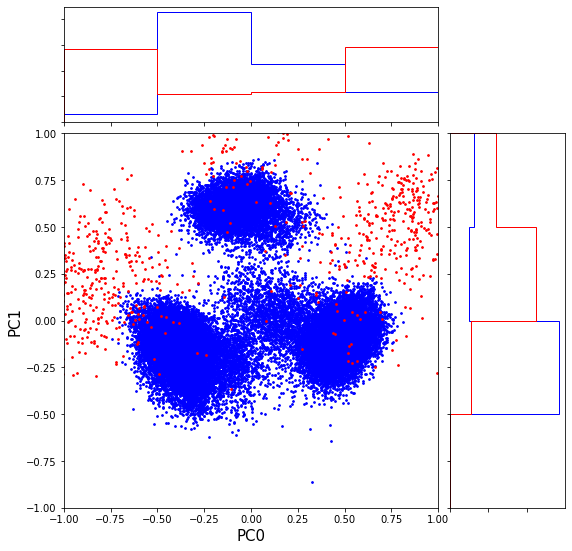

In [9]:
norm.calibrate(evaluate=True)

In [ ]:
norm = Normalise(experiment=texp,
                source_id=all_samples[5],
                root_population='liveCD3',
                features=features,
                reference_sample=reference_sample)
norm.calibrate(evaluate=True)

setting scales using KNN
Scales: [1.5270701099817046, 3.054140219963409, 6.108280439926818]
setting all scale weights to 1
Train on 225311 samples, validate on 25035 samples
Epoch 1/500
225311/225311 [==============================] - 24s 104us/step - loss: 0.3289 - val_loss: 0.8969
Epoch 2/500
225311/225311 [==============================] - 23s 102us/step - loss: 0.1904 - val_loss: 0.5524
Epoch 3/500
225311/225311 [==============================] - 23s 101us/step - loss: 0.1788 - val_loss: 0.2880
Epoch 4/500
225311/225311 [==============================] - 23s 102us/step - loss: 0.1726 - val_loss: 0.2332
Epoch 5/500
225311/225311 [==============================] - 22s 99us/step - loss: 0.1677 - val_loss: 0.2325
Epoch 6/500
225311/225311 [==============================] - 22s 99us/step - loss: 0.1646 - val_loss: 0.2237
Epoch 7/500
225311/225311 [==============================] - 22s 98us/step - loss: 0.1621 - val_loss: 0.2252
Epoch 8/500
225311/225311 [==============================] 